#### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
import random
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from math import pi
from scipy.interpolate import NearestNDInterpolator

%matplotlib inline

#floris simulation modules
from floris.tools.wind_rose import WindRose
from floris.tools import FlorisInterface
import floris.tools.visualization as wakeviz
from floris.turbine_library import TurbineInterface, TurbineLibrary
from floris.tools.visualization import (
    calculate_horizontal_plane_with_turbines,
    visualize_cut_plane,
)

## Optimized Layouts

#### Defining Populations

In [2]:
# def initialize_populations_sample(n):
#     populations = []
#     for _ in range(n):  # Generate 6 initial populations
#         num_turbines = np.random.randint(3, 11)  # Random number of turbines between 3 and 10
#         layout = pd.DataFrame(np.random.randint(1, n, size=(num_turbines, 2)) * 126, columns=['Layout_x', 'Layout_y'])  # Generate coordinates that are multiples of 126 meters
#         layout.iloc[0] = [0, 0]  # Set the first turbine at the origin
#         populations.append(layout)
#     return populations

# def firstpopulation():
#      return [pd.read_csv('./Population_1.csv'), pd.read_csv('./Population_2.csv'), pd.read_csv('./Population_3.csv'), pd.read_csv('./Population_11.csv'), pd.read_csv('./Population_12.csv'), pd.read_csv('./Population_13.csv')]

# populations = initialize_populations_sample(10)
# firtP = firstpopulation()
# for _ in firstpopulation():
#     populations.append(_)

# def initialize_populations():
#     return populations

# len(initialize_populations())

#### Defining Parameters

In [3]:
min_distance = 126
tournament_size = 3
target_coverage_area = 800000
turbine_diameter = 126
mutation_rate = 0.01

### The GA Implmentation

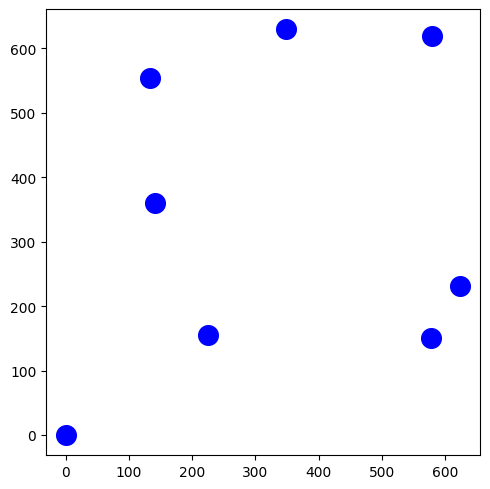

     Layout_x    Layout_y
0    0.000000    0.000000
1  347.987029  629.280459
2  141.884647  360.174236
3  133.672803  553.231993
4  579.455365  618.953574
5  624.160192  230.328172
6  224.719308  155.106103
7  577.158427  149.814183
Enclosed area:  274970.54020825133


In [4]:
def initialize_populations():
    populations = []
    for num_turbines in np.repeat(range(3, 9), 4):  # Generate 24 initial populations
        layout = pd.DataFrame(columns=['Layout_x', 'Layout_y'])
        layout.loc[0] = [0, 0]  # Set the first turbine at the origin
        for _ in range(1, num_turbines):
            while True:
                new_turbine = pd.DataFrame(np.random.uniform(126, 630, size=(1, 2)), columns=['Layout_x', 'Layout_y'])
                if all(np.linalg.norm(layout[['Layout_x', 'Layout_y']].values - new_turbine.values, axis=1) >= 126):
                    temp_df = pd.concat([layout, new_turbine], ignore_index=True)
                    layout = temp_df.copy()  # Assign the concatenated DataFrame back to layout
                    break
        populations.append(layout)
    return populations


def calculate_fitness(layout):
    num_turbines = len(layout)
    distances = scipy.spatial.distance.pdist(layout[['Layout_x', 'Layout_y']].values)
    wake_effect = np.sum(1 / distances)
    return num_turbines - wake_effect

def tournament_selection(populations):
    tournament = random.sample(populations, tournament_size)
    return max(tournament, key=calculate_fitness)

def crossover(parent1, parent2):
    min_length = min(len(parent1), len(parent2))
    child = parent1.copy()

    for column in child.columns:
        random_mask = np.random.rand(min_length) < 0.5
        child_vals = np.where(random_mask, parent1[column][:min_length], parent2[column][:min_length])
        child[column][:min_length] = child_vals

    return child

def mutate(df):
    if np.random.rand() < mutation_rate:
        if len(df) > 3:  # If there are more than 3 turbines, remove one with a certain probability
            df = df.drop(np.random.choice(df.index[1:]))  # Do not remove the turbine at the origin
        elif len(df) < 10:  # If there are less than 10 turbines, add one with a certain probability
            while True:
                new_turbine = pd.DataFrame(np.random.uniform(126, 630, size=(1, 2)), columns=['Layout_x', 'Layout_y'])  # Generate coordinates between 126 and 630 meters
                if all(np.linalg.norm(df[['Layout_x', 'Layout_y']].values - new_turbine.values, axis=1) >= 126):
                    df = df.append(new_turbine, ignore_index=True)
                    break
    return df

def calculate_enclosed_area(layout):
    points = layout[['Layout_x', 'Layout_y']].values
    hull = ConvexHull(points)
    return hull.volume

def run_genetic_algorithm(populations):
    best_layouts = {i: None for i in range(3, 9)}  # Initialize a dictionary to store the best layout for each number of turbines

    for _ in range(20):
        next_gen = []
        for _ in range(len(populations)):
            parent1 = tournament_selection(populations)
            parent2 = tournament_selection(populations)
            child = crossover(parent1, parent2)
            child = mutate(child)
            next_gen.append(child)
        populations = next_gen

    # Sort populations by fitness and enclosed area
    populations.sort(key=lambda p: (calculate_fitness(p), -calculate_enclosed_area(p)), reverse=True)

    # Update best_layouts with the best layout for each number of turbines
    for population in populations:
        num_turbines = len(population)
        if 3 <= num_turbines <= 8 and best_layouts[num_turbines] is None and calculate_enclosed_area(population) <= 800000:
            best_layouts[num_turbines] = population

    # If all layouts exceed 800,000 sq meters, return the one with the smallest area
    for num_turbines in range(3, 9):
        if best_layouts[num_turbines] is None:
            best_layouts[num_turbines] = min(populations, key=calculate_enclosed_area)

    # Return a layout with a random number of turbines from 3 to 8
    return best_layouts[np.random.choice(range(3, 9))]

def plot_best_layout(best_layout):
    fig, ax = plt.subplots(figsize=(5, 5))  # Adjust subplot configuration
    ax.scatter(best_layout['Layout_x'], best_layout['Layout_y'], c='b', s=200)
    # ax.set_title('Best Layout')
    plt.tight_layout()
    plt.show()

def main():
    populations = initialize_populations()
    best_layout = run_genetic_algorithm(populations)  # Get only the best layout

    plot_best_layout(best_layout)  # Plot only the best layout
    print(best_layout)
    print("Enclosed area: ", calculate_enclosed_area(best_layout))

if __name__ == "__main__":
    main()

In [5]:
def initialize_populations():
    populations = []
    for num_turbines in np.repeat(range(3, 9), 4):  # Generate 24 initial populations
        layout = pd.DataFrame(columns=['Layout_x', 'Layout_y'])
        layout.loc[0] = [0, 0]  # Set the first turbine at the origin
        for _ in range(1, num_turbines):
            while True:
                new_turbine = pd.DataFrame(np.random.uniform(126, 630, size=(1, 2)), columns=['Layout_x', 'Layout_y'])
                if all(np.linalg.norm(layout[['Layout_x', 'Layout_y']].values - new_turbine.values, axis=1) >= 126):
                    temp_df = pd.concat([layout, new_turbine], ignore_index=True)
                    layout = temp_df.copy()  # Assign the concatenated DataFrame back to layout
                    break
        populations.append(layout)
    return populations


populations_sa = initialize_populations()
for _ in populations_sa:
    print(len(_))

3
3
3
3
4
4
4
4
5
5
5
5
6
6
6
6
7
7
7
7
8
8
8
8


In [6]:
def plot_best_layouts(best_layout):
    fig, ax = plt.subplots(figsize=(5, 5))  # Adjust subplot configuration
    ax.scatter(best_layout['Layout_x'], best_layout['Layout_y'], c='b', s=200)

    # Calculate and plot Convex Hull
    points = best_layout[['Layout_x', 'Layout_y']].values
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], 'k-')

    # Shade the area enclosed by the Convex Hull
    ax.fill(points[hull.vertices,0], points[hull.vertices,1], 'k', alpha=0.3)

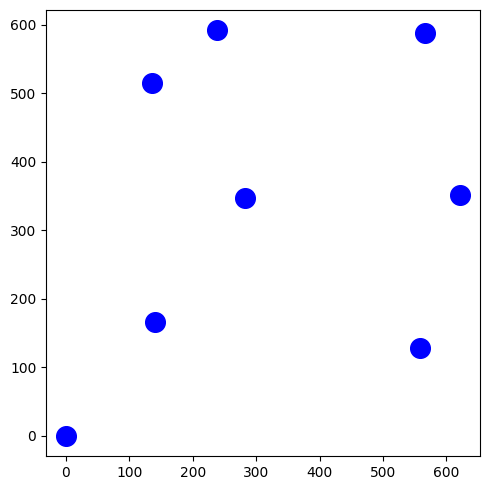

260743.57213911932


8

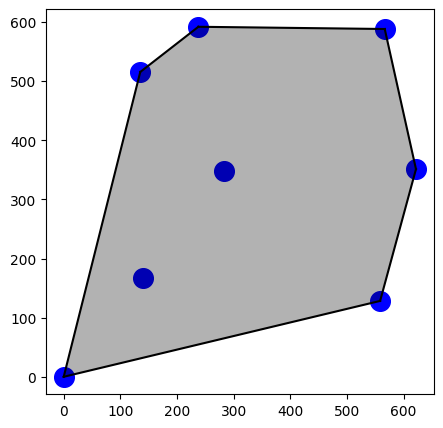

In [7]:
populations = initialize_populations()
best_layout = run_genetic_algorithm(populations)  # Get only the best layout
plot_best_layout(best_layout)  # Plot only the best layout
plot_best_layouts(best_layout)
print(calculate_enclosed_area(best_layout))
len(best_layout)

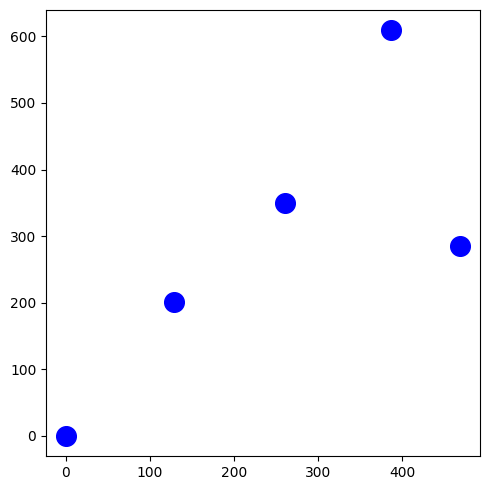

87670.39069459811


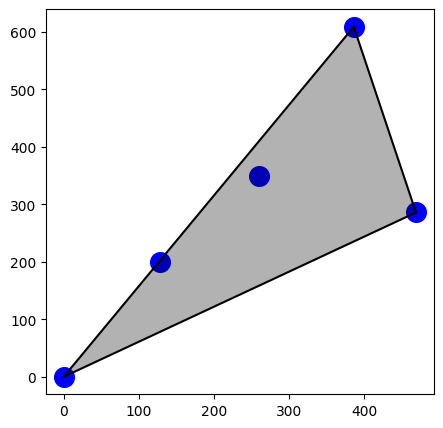

In [8]:
plot_best_layout(populations[10])  # Plot only the best layout
plot_best_layouts(populations[10])
print(calculate_enclosed_area(populations[10])) 

### Generation 1 Population

In [9]:
def get_gen1_populations():
    gen_1_pop = []
    for _ in range(40):
        best_layout = run_genetic_algorithm(populations)
        gen_1_pop.append(best_layout)
    return gen_1_pop

gen_1_pop = get_gen1_populations()
gen_1_pop[0]

AttributeError: 'DataFrame' object has no attribute 'append'

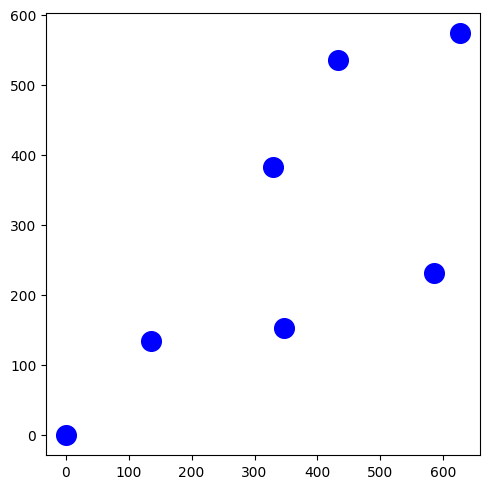

244151.20350999784


8

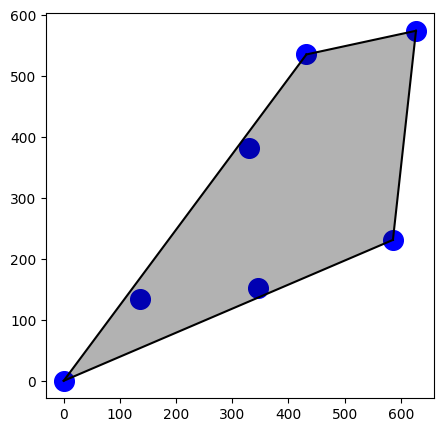

In [ ]:
plot_best_layout(gen_1_pop[20])  # Plot only the best layout
plot_best_layouts(gen_1_pop[20])
print(calculate_enclosed_area(gen_1_pop[1]))
len(gen_1_pop[1])   # 10

## Wind Power With Floris Interface

#### Wind Rose

In [ ]:
df_wind_montly = pd.read_csv('./2020_Daily_Avgs.csv')
df_wind_montly.head()

list_wd_bins = [0., 5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60., 65., 70., 75., 80., 85., 90., 95., 100., 105., 110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160., 165., 170., 175., 180., 185., 190., 195., 200., 205., 210., 215., 220., 225., 230., 235., 240., 245., 250., 255., 260., 265., 270., 275., 280., 285., 290., 295., 300., 305., 310., 315., 320., 325., 330., 335., 340., 345., 350., 355.]

list_ws_bins = [0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.]

windr = WindRose()

df_wind_calc = windr.make_wind_rose_from_user_data(wd_raw=df_wind_montly['average_wind_dir_deg'], ws_raw=df_wind_montly['Factorized_Mean'], wd=np.array(list_wd_bins), ws=np.array(list_ws_bins))

Correcting negative Overhang:-2.5


In [ ]:
wd_array = np.array(df_wind_calc["wd"].unique(), dtype=float)
ws_array = np.array(df_wind_calc["ws"].unique(), dtype=float)


wd_grid, ws_grid = np.meshgrid(wd_array, ws_array, indexing="ij")
freq_interp = NearestNDInterpolator(df_wind_calc[["wd", "ws"]], df_wind_calc["freq_val"])
freq = freq_interp(wd_grid, ws_grid)

# Normalize the frequency array to sum to exactly 1.0
freq = freq / np.sum(freq)

### Floris Initialization

In [ ]:
fi_nrel = FlorisInterface('./gch.yaml')
fi_vestas = FlorisInterface('./gch_vestas.yaml')

In [ ]:
fi_nrel.reinitialize(
    layout_x=gen_1_pop[4]["Layout_x"],
    layout_y=gen_1_pop[4]['Layout_y'],
    wind_directions=wd_array,
    wind_speeds=ws_array,
)

In [ ]:
aep_no_wake = fi_nrel.get_farm_AEP(freq, no_wake=True)
print("Farm AEP (no_wake=True): {:.3f} GWh".format(aep_no_wake / 1.0e9))

Farm AEP (no_wake=True): 99.403 GWh


### With AEP Included

In [ ]:
def powers(fi, gen_1_pop):
    power_list = []
    fi.reinitialize(
        layout_x=gen_1_pop["Layout_x"],
        layout_y=gen_1_pop['Layout_y'],
        wind_directions=wd_array,
        wind_speeds=ws_array,
    )

    aep = fi.get_farm_AEP(
        freq=freq,
        cut_in_wind_speed=4.0,  # Wakes are not evaluated below this wind speed
        cut_out_wind_speed=25.0,  # Wakes are not evaluated above this wind speed
    )
    power_list.append(round((aep / 1.0e9), 3))

    aep_no_wake = fi.get_farm_AEP(freq, no_wake=True)
    power_list.append(round((aep_no_wake / 1.0e9), 3))

    percentage_power_loss = (aep_no_wake - aep) / aep_no_wake * 100
    power_list.append(round(percentage_power_loss, 3))


    return power_list


# nrel_p1_powers[]

for _ in range(len(gen_1_pop)):
    nrel_p1_powers = powers(fi_nrel, gen_1_pop[_])
    print(nrel_p1_powers)

# for _ in range(len(populations)):
#     nrel_p1_powers = powers(fi_nrel, populations[_])
#     print(nrel_p1_powers)
# nrel_p1_powers = powers(fi_nrel, gen_1_pop[0])
# nrel_p1_powers

[69.726, 99.403, 29.855]
[70.877, 99.403, 28.697]
[75.08, 99.403, 24.469]
[69.898, 99.403, 29.682]
[69.914, 99.403, 29.666]
[71.006, 99.403, 28.567]
[62.509, 86.978, 28.132]
[69.377, 99.403, 30.206]
[65.186, 86.978, 25.054]
[65.46, 86.978, 24.739]
[72.076, 99.403, 27.491]
[73.955, 99.403, 25.601]
[68.41, 99.403, 31.18]
[68.248, 86.978, 21.534]
[68.654, 99.403, 30.934]
[73.228, 99.403, 26.332]
[66.739, 86.978, 23.269]
[72.015, 99.403, 27.553]
[72.996, 99.403, 26.566]
[68.559, 99.403, 31.03]
[58.885, 86.978, 32.299]
[74.261, 99.403, 25.293]
[65.205, 86.978, 25.033]
[72.604, 99.403, 26.96]
[69.395, 99.403, 30.189]
[73.888, 99.403, 25.668]
[65.183, 99.403, 34.426]
[72.071, 99.403, 27.496]
[72.745, 99.403, 26.818]
[74.854, 99.403, 24.696]
[73.563, 99.403, 25.996]
[71.106, 99.403, 28.468]
[62.721, 86.978, 27.888]
[70.912, 99.403, 28.662]
[74.84, 99.403, 24.711]
[67.688, 99.403, 31.905]
[66.552, 99.403, 33.048]
[66.311, 99.403, 33.291]
[70.35, 99.403, 29.228]
[74.694, 99.403, 24.857]
